In [7]:
#get dataframe of tweet_id and user_id
import pandas
import csv

df = pandas.read_csv('gamergate_tweets.csv')

In [8]:
import sys
sys.path.append("/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages")

from twython import Twython

#get first 5000 tweet_ids
CONSUMER_KEY = "48r56upQvsnTiSDfY4CNwIpCQ"
CONSUMER_SECRET = "VqZhFW7GqogdKXJnpuS0umVe211bFgoCdaQlRdRMayvrbdDh3k"
OAUTH_TOKEN = "18000528-Scl8a1pLinqP4KWtaa3f8EN0M1vqAGTyYXMtsLIGm"
OAUTH_TOKEN_SECRET = "NcIvLeqVbwwBegabvo7946FVIaDN0CAaJ7aS2aV7pZFzC"

twitter = Twython(
    CONSUMER_KEY, CONSUMER_SECRET,
    OAUTH_TOKEN, OAUTH_TOKEN_SECRET)


start = 0
end = 100
tweet_list = []
while end <= 5000:
    id_list = df["tweet_id"].tolist()
    current = id_list[start:end]
    tweet = twitter.lookup_status(id=current)
    start += 100
    end += 100
    for t in tweet:
        each_tweet = []
        each_tweet.append(t['user']['id'])
        each_tweet.append(t["retweet_count"])
        each_tweet.append(t["favorite_count"])
        if t["entities"]['urls'] != []:
            each_tweet.append(1)
        else: each_tweet.append(0)
        if t["entities"]["user_mentions"] == []:
            each_tweet.append([])
        else: 
            y = 0
            mentionlist = []
            while y < len(t["entities"]["user_mentions"]):
                mentionlist.append((t["entities"]["user_mentions"])[y].items()[2][1])
                y+=1
            each_tweet.append(mentionlist)
        each_tweet.append(t["text"])
        tweet_list.append(each_tweet)

In [9]:
#put into df    
tweets_df = pandas.DataFrame(tweet_list, columns=["User ID", "Retweets", "Favorites", "Has_url", "Mentions", "Text"])

         User ID  Retweets  Favorites  Has_url  \
0       20708129       363          0        0   
1       20945241         1          0        0   
2      251045973         0          0        0   
3     1091189214         1          0        0   
4     2847688135         0          0        1   
5     2798609018         0          0        0   
6     2492324996       794          0        1   
7       93363347       238          0        1   
8      937178150        27          0        0   
9       36790442         0          0        1   
10    2590712055        33          0        1   
11      16326705       969          0        0   
12     985889652        80          0        1   
13      18746944       238          0        1   
14     162572003         0          1        0   
15     940132086       229          0        0   
16      49534986        19          0        0   
17     171848975         0          0        0   
18      49724410         0          0        0   


In [4]:
import re
import sys
from nltk.sentiment.vader import SentimentIntensityAnalyzer

In [18]:
#Use Vader sentiment analysis to get polarity
tweetlist = tweets_df["Text"].tolist()
sentences = []
for x in tweetlist:
    x = re.sub(r"(?:\@|https?\://)\S+", "", x)
    sentences.append(x)

polarity = []
SIA = SentimentIntensityAnalyzer()
for sentence in sentences:
    ss = SIA.polarity_scores(sentence)
    for k in sorted(ss):
        polarity.append(ss[k])


[-0.3182, 0.161, 0.839, 0.0, -0.1027]


In [22]:
#use lexicon to get polarity of each tweet
'''
#read and put positive words into list
with open('positive-words.txt') as f:
    positive = f.read().splitlines()
#trim list    
positive = positive[35:]
positive = set(positive)

#read and put negative words into list
with open('negative-words.txt') as f:
    negative = f.read().splitlines()
#trim list    
negative = negative[35:]
#remove problematic "naive"
negative.remove(negative[3007])
negative = set(negative)
    
lexrating = []
poscount = 0
negcount = 0

x = 0

for tweet in tweets_df["Text"]:
    words = tweet.split()
    for word in words:
        if word in positive:
            poscount = poscount + 1
        elif word in negative:
            negcount = negcount + 1
            
    #get polarity of tweet
    if negcount == 0: ratio = poscount
    elif poscount == 0: ratio = negcount * -1
    else : 
        if poscount > negcount: ratio = poscount - negcount
        else: ratio = (negcount - poscount) * -1
    
    lexrating.append(ratio)

    poscount = 0
    negcount = 0
    x += 1
'''        
    #add column of lexrating reviews
tweets_df["Polarity"] = pandas.Series(polarity)
    



#polaritylist = tweets_df["Polarity"].tolist()
likelist = tweets_df["Favorites"].tolist()
retweetlist = tweets_df["Retweets"].tolist()

#Create Popularity column, where popularity = num(Retweets) + num(Favorites)
x = 0
popularity = []
while x < len(likelist):
    popularity.append(likelist[x] + retweetlist[x])
    x+=1

tweets_df["Popularity"] = pandas.Series(popularity)

#get nummentions column
numMentions = tweets_df["Mentions"].tolist()
mentionsCount = []
for x in numMentions:
    mentionsCount.append(len(x))
    
tweets_df["numMentions"] = pandas.Series(mentionsCount)


print tweets_df
    

         User ID  Retweets  Favorites  Has_url  \
1332  2469972416       293          0        1   
544    180548361         1          0        0   
3024     6371492       969          0        0   
700    383883683         0          0        1   
1388  2811698041        78          0        1   
692   2844993576         0          0        0   
2736  2585165988         0          0        0   
1356  2815279566         0          0        0   
2688  2806358985         0          0        0   
180   2782756512         0          0        0   
2960  1499808391        27          0        0   
3380  2793323140         3          2        0   
1064  2793807454         0          0        0   
640     97708712         0          0        0   
3328  2756744663         2          0        0   
2600   397405481         0          1        0   
268   1132062200         5          8        0   
2720    58661424         1          0        0   
328   2811698041        11          0        1   


In [20]:
tweets_df = tweets_df.sort_values("Polarity")
pop = tweets_df["Popularity"].tolist()
hasurl = tweets_df["Has_url"].tolist()
mentions = tweets_df["Mentions"].tolist()
pol = tweets_df["Polarity"].tolist()

nummentions = []
for x in mentions:
    nummentions.append(len(x))

pol_labels = []    
for x in pol:
    if x not in pol_labels:
        pol_labels.append(x)
        
#get count for has_mentions or has_no_mentions
hascount = 0
nothascount = 0
count = 0
mentionhascount = []
mentionnothascount = []
current = pol[0]
for x in pol:
    if x == current:
        if mentions[count] == []:
            nothascount+=1
        else:
            hascount+=1
    else:
        mentionhascount.append(hascount)
        mentionnothascount.append(nothascount)
        hascount = 0
        nothascount = 0
    count+=1 
    current = x
    
mentionhascount.append(hascount)
mentionnothascount.append(nothascount)

#get count for has_url and not has_url
hascount = 0
nothascount = 0
count = 0
urlhascount = []
urlnothascount = []
current = pol[0]
for x in pol:
    if x == current:
        if hasurl[count] == 0:
            nothascount+=1
        else:
            hascount+=1
    else:
        urlhascount.append(hascount)
        urlnothascount.append(nothascount)
        hascount = 0
        nothascount = 0
    count+=1 
    current = x
    
urlhascount.append(hascount)
urlnothascount.append(nothascount)
    
x = 0
poplist = []
hasurllist = []
pollist = []
mentionlist = []
while x < len(pop):
    hasurllist.append(hasurl[x])
    poplist.append(pop[x])
    pollist.append(abs(pol[x])) 
    mentionlist.append(nummentions[x])
    x+=1

                            OLS Regression Results                            
Dep. Variable:             Popularity   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     1.234
Date:                Fri, 08 Apr 2016   Prob (F-statistic):              0.267
Time:                        21:22:00   Log-Likelihood:                -23315.
No. Observations:                3392   AIC:                         4.663e+04
Df Residuals:                    3390   BIC:                         4.665e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept     86.4683      4.519     19.135      0.0

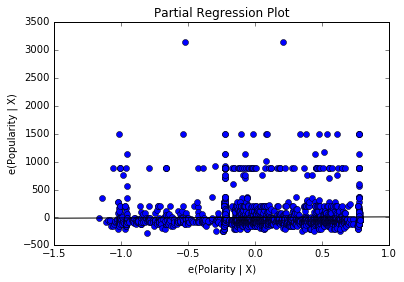

In [37]:
import statsmodels.formula.api as smf

mod = smf.ols(formula='Popularity ~ Polarity + numMentions + Has_url + Retweets + Favorites', data=tweets_df)
res = mod.fit()
print(res.summary())

sm.graphics.plot_partregress('Popularity', 'Polarity', 'numMentions', data=tweets_df, obs_labels=False)

mod = smf.ols(formula='Polarity ~ Popularity + numMentions + Has_url + Retweets + Favorites', data=tweets_df)
res = mod.fit()
print(res.summary())
